In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn import set_config
set_config(display='diagram') # Để trực quan hóa pipeline

[Request Link](https://globalweather.tamu.edu/request/view/36316)\
[Direct download](https://globalweather.tamu.edu/data/cfsr/36316_2020-12-31-02-56-09.zip)

In [3]:
df = pd.read_csv('weatherdata-1611081.csv', index_col=False)
df

,Date,Longitude,Latitude,Elevation,Max Temperature,Min Temperature,Precipitation,Wind,Relative Humidity,Solar
0,1/1/1979,108.125,16.0798,21,21.789,20.032,8.433718,2.442694,0.945526,6.279357
1,1/2/1979,108.125,16.0798,21,22.050,19.974,1.917458,2.021508,0.923605,4.131790
2,1/3/1979,108.125,16.0798,21,22.847,19.485,0.520134,1.363726,0.865097,6.813003
3,1/4/1979,108.125,16.0798,21,22.304,18.682,0.224876,1.887963,0.862533,9.143603
4,1/5/1979,108.125,16.0798,21,23.549,19.568,0.509834,2.179407,0.865400,10.840449
...,...,...,...,...,...,...,...,...,...,...
12923,7/27/2014,108.125,16.0798,21,27.654,22.145,123.403941,0.722276,0.960563,11.988250
12924,7/28/2014,108.125,16.0798,21,27.882,22.253,38.002393,0.805266,0.950569,21.488302
12925,7/29/2014,108.125,16.0798,21,28.599,20.573,20.422551,0.824725,0.943231,9.977630
12926,7/30/2014,108.125,16.0798,21,27.441,21.986,24.712369,1.054239,0.960196,23.610801


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12928 entries, 0 to 12927
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               12928 non-null  object 
 1   Longitude          12928 non-null  float64
 2   Latitude           12928 non-null  float64
 3   Elevation          12928 non-null  int64  
 4   Max Temperature    12928 non-null  float64
 5   Min Temperature    12928 non-null  float64
 6   Precipitation      12928 non-null  float64
 7   Wind               12928 non-null  float64
 8   Relative Humidity  12928 non-null  float64
 9   Solar              12928 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1010.1+ KB


In [ ]:
display_range = 5000
for col in [ 'Max Temperature', 'Min Temperature', 'Precipitation', 'Wind', 'Relative Humidity','Solar']:
    plt.figure(figsize=(20,5))
    plt.scatter(pd.RangeIndex(start=0, stop=display_range, step=1), df[col].head(display_range))
    plt.title(label=col)

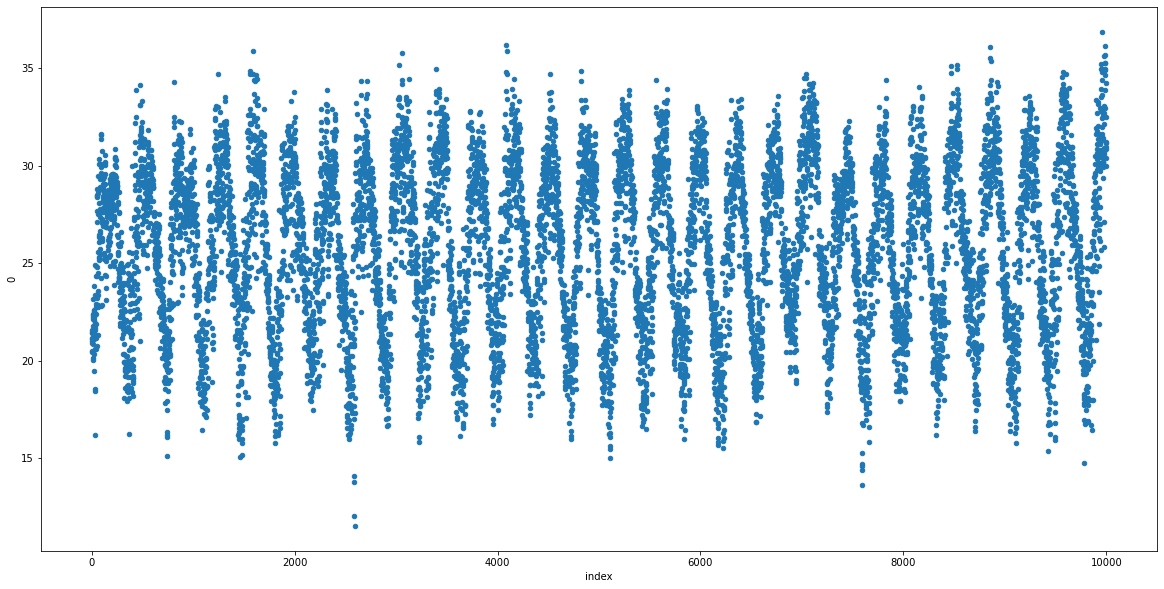

In [6]:
mean_temp = (df['Max Temperature'] + df['Min Temperature'])/2
mean_temp.head(10000).reset_index().plot(x='index', y=0, kind = 'scatter', figsize=[20,10])

In [8]:
df.insert(loc=3, column='Mean Temperature', value=mean_temp)
df

,Date,Longitude,Latitude,Mean Temperature,Elevation,Max Temperature,Min Temperature,Precipitation,Wind,Relative Humidity,Solar
0,1/1/1979,108.125,16.0798,20.9105,21,21.789,20.032,8.433718,2.442694,0.945526,6.279357
1,1/2/1979,108.125,16.0798,21.0120,21,22.050,19.974,1.917458,2.021508,0.923605,4.131790
2,1/3/1979,108.125,16.0798,21.1660,21,22.847,19.485,0.520134,1.363726,0.865097,6.813003
3,1/4/1979,108.125,16.0798,20.4930,21,22.304,18.682,0.224876,1.887963,0.862533,9.143603
4,1/5/1979,108.125,16.0798,21.5585,21,23.549,19.568,0.509834,2.179407,0.865400,10.840449
...,...,...,...,...,...,...,...,...,...,...,...
12923,7/27/2014,108.125,16.0798,24.8995,21,27.654,22.145,123.403941,0.722276,0.960563,11.988250
12924,7/28/2014,108.125,16.0798,25.0675,21,27.882,22.253,38.002393,0.805266,0.950569,21.488302
12925,7/29/2014,108.125,16.0798,24.5860,21,28.599,20.573,20.422551,0.824725,0.943231,9.977630
12926,7/30/2014,108.125,16.0798,24.7135,21,27.441,21.986,24.712369,1.054239,0.960196,23.610801


---
# Derive n<sup>th</sup> day features pipeline (and drop some unnecessary columns):

In [24]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, nth_day_features=0):
        self.nth_day_features = nth_day_features
    def fit(self, X_df, y=None):
        return self
    def derive_nth_day_feature(self, X, feature, N):
        rows = X.shape[0]
        nth_prior_measurements = [None]*N + [X[feature][i-N] for i in range(N, rows)]
        col_name = "{} {}".format(feature, N)
        X[col_name] = nth_prior_measurements
    def transform(self, X, y=None):
        X_cl = X.copy()
        drop_col = X_cl.columns
        X_cl.drop(['Longitude','Latitude','Elevation','Date', 'Mean Temperature'], axis=1, errors='ignore', inplace=True)
        for feature in X_cl.columns:
            for N in range(1, self.nth_day_features + 1):
                self.derive_nth_day_feature(X_cl, feature, N)
        X_cl.drop(drop_col, axis=1, errors='ignore', inplace=True)
        X_cl.fillna(method='bfill', inplace=True)
        return X_cl

In [19]:
coladderdropper = make_pipeline(ColAdderDropper(nth_day_features=3))
preprocessed_train_X = coladderdropper.transform(df)
preprocessed_train_X

,Max Temperature 1,Max Temperature 2,Max Temperature 3,Min Temperature 1,Min Temperature 2,Min Temperature 3,Precipitation 1,Precipitation 2,Precipitation 3,Wind 1,Wind 2,Wind 3,Relative Humidity 1,Relative Humidity 2,Relative Humidity 3,Solar 1,Solar 2,Solar 3
0,21.789,21.789,21.789,20.032,20.032,20.032,8.433718,8.433718,8.433718,2.442694,2.442694,2.442694,0.945526,0.945526,0.945526,6.279357,6.279357,6.279357
1,21.789,21.789,21.789,20.032,20.032,20.032,8.433718,8.433718,8.433718,2.442694,2.442694,2.442694,0.945526,0.945526,0.945526,6.279357,6.279357,6.279357
2,22.050,21.789,21.789,19.974,20.032,20.032,1.917458,8.433718,8.433718,2.021508,2.442694,2.442694,0.923605,0.945526,0.945526,4.131790,6.279357,6.279357
3,22.847,22.050,21.789,19.485,19.974,20.032,0.520134,1.917458,8.433718,1.363726,2.021508,2.442694,0.865097,0.923605,0.945526,6.813003,4.131790,6.279357
4,22.304,22.847,22.050,18.682,19.485,19.974,0.224876,0.520134,1.917458,1.887963,1.363726,2.021508,0.862533,0.865097,0.923605,9.143603,6.813003,4.131790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12923,29.872,30.240,29.414,20.916,21.603,22.036,35.108186,12.417981,14.024733,1.024239,1.409729,1.177197,0.934210,0.859401,0.949481,14.209014,9.487448,8.634759
12924,27.654,29.872,30.240,22.145,20.916,21.603,123.403941,35.108186,12.417981,0.722276,1.024239,1.409729,0.960563,0.934210,0.859401,11.988250,14.209014,9.487448
12925,27.882,27.654,29.872,22.253,22.145,20.916,38.002393,123.403941,35.108186,0.805266,0.722276,1.024239,0.950569,0.960563,0.934210,21.488302,11.988250,14.209014
12926,28.599,27.882,27.654,20.573,22.253,22.145,20.422551,38.002393,123.403941,0.824725,0.805266,0.722276,0.943231,0.950569,0.960563,9.977630,21.488302,11.988250


---

In [20]:
X = coladderdropper.transform(df)
y = df['Mean Temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [23]:

# instantiate the regressor class
#regressor = LinearRegression()

# fit the build the model by fitting the regressor to the training data
#regressor.fit(X_train, y_train)

linear_pipeline = make_pipeline(coladderdropper, LinearRegression())

linear_pipeline.fit(X_train,y_train)
# make a prediction set using the test set
prediction = linear_pipeline.predict(X_test)

# Evaluate the prediction accuracy of the model
from sklearn.metrics import mean_absolute_error, median_absolute_error
print("The Explained Variance: %f" % regressor.score(X_test, y_test))
print("The Mean Absolute Error: %f degrees celsius" % mean_absolute_error(y_test, prediction))
print("The Median Absolute Error: %f degrees celsius" % median_absolute_error(y_test, prediction))

KeyError: 4

---

# Using Neural Network:

In [20]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

In [21]:
predictors =['Max Temperature 1', 'Max Temperature 2', 
             'Min Temperature 1', 'Min Temperature 2',
             'Precipitation 1', 'Precipitation 2', 
             'Wind 1', 'Wind 2',
             'Relative Humidity 1', 'Relative Humidity 2', 
             'Solar 1', 'Solar 2']
output_vars = ['Max Temperature', 'Min Temperature','Precipitation']

X = df[predictors]
y = df[output_vars]

In [22]:
display(X.head(5))
display(y.head(5))

,Max Temperature 1,Max Temperature 2,Min Temperature 1,Min Temperature 2,Precipitation 1,Precipitation 2,Wind 1,Wind 2,Relative Humidity 1,Relative Humidity 2,Solar 1,Solar 2
3,22.847,22.050,19.485,19.974,0.520134,1.917458,1.363726,2.021508,0.865097,0.923605,6.813003,4.131790
4,22.304,22.847,18.682,19.485,0.224876,0.520134,1.887963,1.363726,0.862533,0.865097,9.143603,6.813003
5,23.549,22.304,19.568,18.682,0.509834,0.224876,2.179407,1.887963,0.865400,0.862533,10.840449,9.143603
6,24.410,23.549,18.392,19.568,0.010300,0.509834,2.584719,2.179407,0.837970,0.865400,20.021504,10.840449
7,23.953,24.410,16.938,18.392,0.163078,0.010300,1.309522,2.584719,0.881904,0.837970,12.011401,20.021504


,Max Temperature,Min Temperature,Precipitation
3,22.304,18.682,0.224876
4,23.549,19.568,0.509834
5,24.410,18.392,0.010300
6,23.953,16.938,0.163078
7,24.352,18.549,0.118446


In [23]:
df[set(df.columns)-set(predictors)].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Mean Temperature,12925.0,25.556551,4.329743,11.520500,22.190500,25.778500,29.061500,37.240000
Max Temperature,12925.0,29.791186,6.179657,13.125000,24.897000,30.002000,34.770000,46.173000
Relative Humidity,12925.0,0.801126,0.131142,0.258958,0.708397,0.825385,0.913693,0.994881
Solar,12925.0,16.313347,8.832827,0.000000,8.827703,18.185858,23.853378,29.411329
Wind,12925.0,2.044396,0.746069,0.297345,1.537092,1.925574,2.405015,10.332604
Mean Temperature 2,12925.0,25.555932,4.330093,11.520500,22.189500,25.778500,29.061500,37.240000
Min Temperature,12925.0,21.321917,2.992306,5.871000,19.417000,21.888000,23.539000,29.249000
Precipitation,12925.0,8.078341,15.994444,0.000000,0.027466,2.221299,9.534073,236.429173
Mean Temperature 1,12925.0,25.556219,4.329915,11.520500,22.190500,25.778500,29.061500,37.240000


In [24]:
# Tách tập huấn luyện và tập validation theo tỉ lệ 80:20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
print(X_train.shape)
print(y_train.shape)

(10340, 12)
(10340, 3)


In [29]:
pipeline = make_pipeline(StandardScaler(), 
                         MLPRegressor(hidden_layer_sizes=(8,8,8), activation='tanh', solver='adam', max_iter=5000))
train_errs = []
val_errs = []
alphas = [0.01, 0.015, 0.1, 0.4, 1, 3]
best_val_err = float('inf'); best_alpha = None;
                         
for alpha in alphas:
    pipeline.set_params(mlpregressor__alpha = alpha)
    pipeline.fit(X_train, y_train)
    train_err = (1 - pipeline.score(X_train, y_train))*100
    val_err = (1 - pipeline.score(X_val, y_val))*100
    if val_err < best_val_err:
        best_val_err = val_err
        best_alpha = alpha
    train_errs.append(train_err)
    val_errs.append(val_err)
'Done'

'Done'

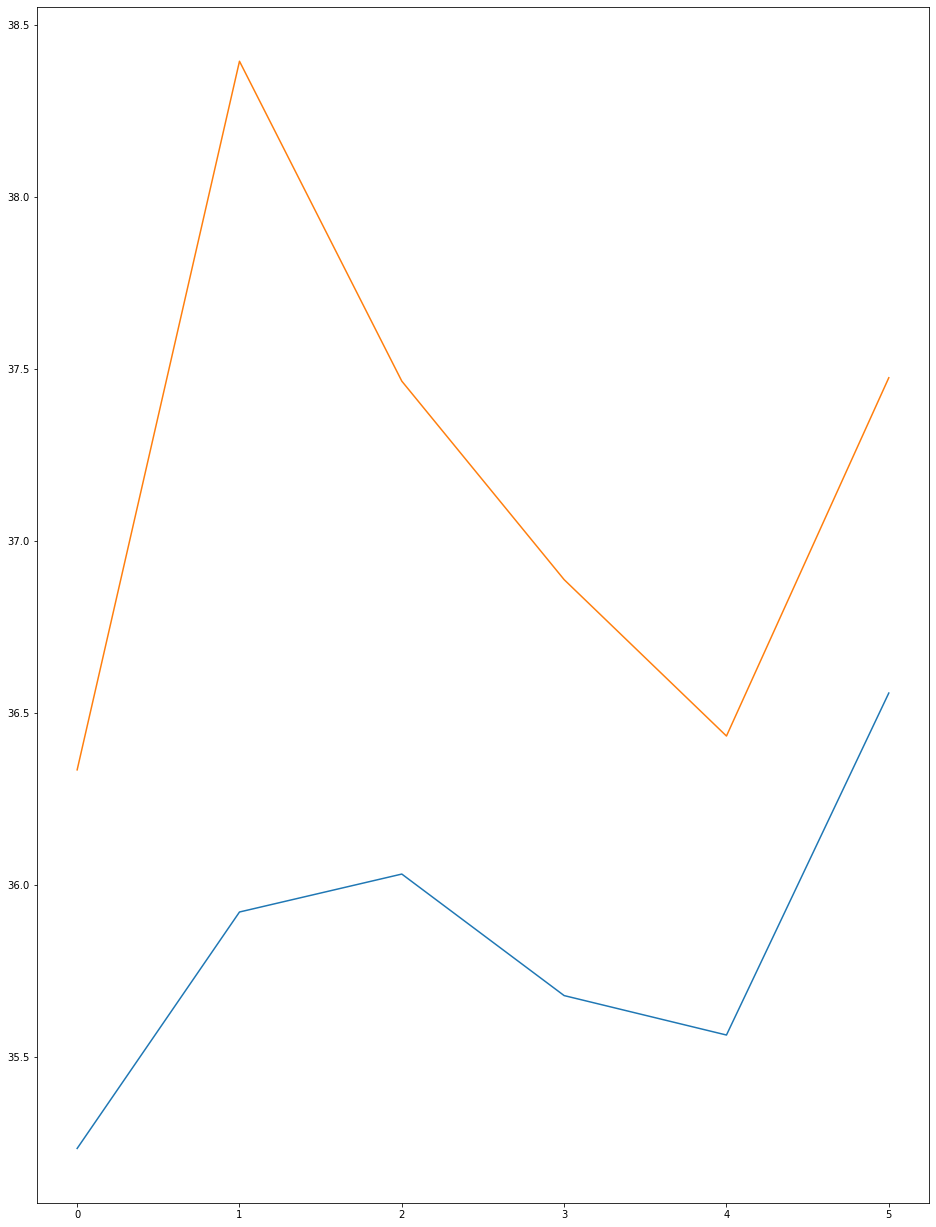

In [30]:
plt.plot(train_errs)
plt.plot(val_errs)